# TLS Characterization of UA Q2
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 1 # for UA Q2
res_index = 1 # for UA Q2
flux_index = 1 # for UA Q2
TLS_index = 1

2024-05-09 10:59:28,061 - qm - INFO     - Starting session: 4f206ede-92a1-4f2f-96b6-b4cc40f79726


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-05-03 20:16:17,649 - qm - INFO     - Octave "octave1" Health check passed, current temperature 56


INFO:qm:Octave "octave1" Health check passed, current temperature 56


2024-05-03 20:16:17,652 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-05-03 20:16:17,686 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [92]:
# change gain RF line for qubit
machine.qubits[qubit_index].rf_gain = 0
machine = Analysis.set_machine(machine)

# TLS experiments

## Set TLS index

In [4]:
TLS_index = 2

## TLS T1

In [17]:
# set to qubit freq
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [3]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-05-09 09:30:03,251 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-05-09 09:30:03,255 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-05-09 09:30:03,272 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2024-05-09 09:30:05,319 - qm - WARNING  - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 


2024-05-09 09:30:05,321 - qm - WARNING  - Open QM ended with warning 0: Quantum Machine qm-1715272187709 is canceling running job 1715213920649.


------------------------------------- Calibrates r1 for (LO, IF) = (7.183 GHz, -50.000 MHz)
2024-05-09 09:30:11,559 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (5.204 GHz, 200.000 MHz)
2024-05-09 09:30:26,170 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [21]:
%matplotlib qt
tau_sweep_abs = np.arange(1E3,5000E3+1,2E5)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 5000E3, simulate_flag = False, simulation_len = 15_000, 
                   plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 930.06s


Qubit T1 [us]: 1620.7067149821692


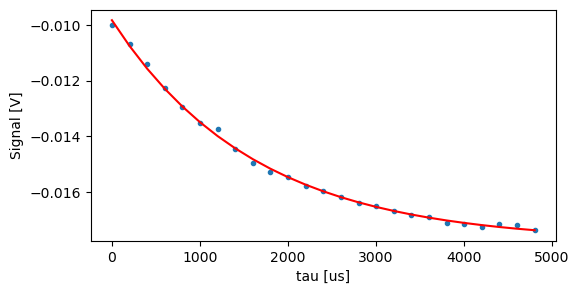

In [23]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,-sig_amp,method = "exp")

# TLS drive

## TLS spectroscopy

### This cell is only for the first run, to estimate TLS freq

In [7]:
TLS_index = 1

In [ ]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.item()) + 0E6)
    machine.qubits[qubit_index].lo = int(TLS_freq_est.item()) - 200E6
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.item()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.item()) - 200E6
machine = Analysis.set_machine(machine)

### This is when we already have calibrated TLS freq saved somewhere

In [8]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [13]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-05-08 17:46:02,643 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-05-08 17:46:02,654 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.183 GHz, -50.000 MHz)
2024-05-08 17:46:11,394 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (5.204 GHz, 200.000 MHz)
2024-05-08 17:46:26,442 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [10]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-5E6,5E6+1,0.5E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 421.93s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 422.03s


resonant frequency: 5403.895 MHz


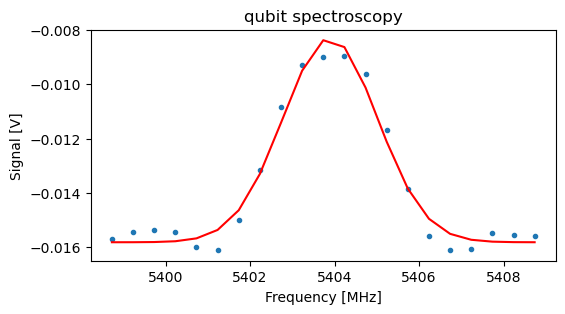

In [12]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=-sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
# update TLS freq
machine.qubits[qubit_index].f_tls[TLS_index] = qubit_freq + 0E6
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
# save the parameters
machine = Analysis.set_machine(machine)

## TLS rabi

In [25]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 200 + 0.1, 5)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 5000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 803.16s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 803.23s


T2rabi: 403.7 ns
rabi_pi_pulse: 1359.2 ns
half period: 1280.00 ns


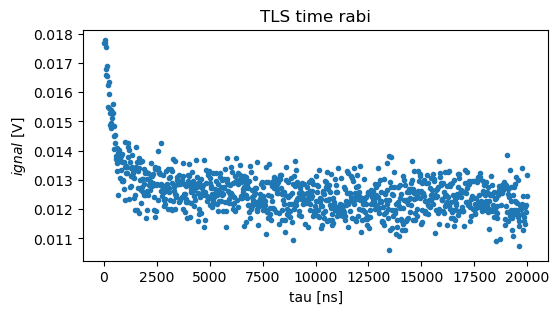

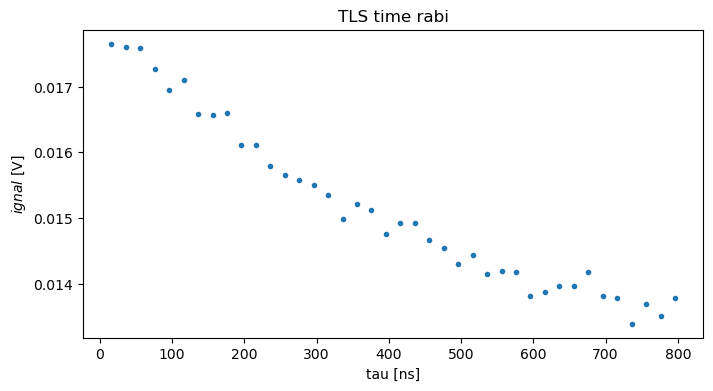

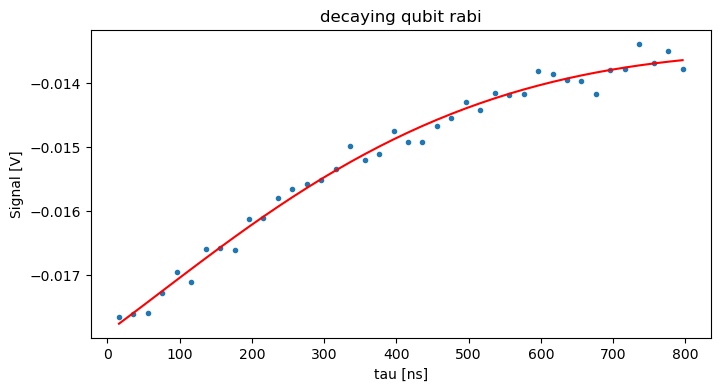

Execution stopped by user!
Execution stopped by user!


In [26]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,-sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [15]:
pi_length = 320
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(pi_length)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = pi_length    
machine.qubits[qubit_index].pi_length_tls[0] = pi_length
machine = Analysis.set_machine(machine)

## TLS Power Rabi

In [38]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0, 1.5, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = False, machine = machine)

some abs amps > 0.5, removed from experiment run
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 161.52s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 161.57s


rabi_pi_pulse_amp: 0.56014 V
half period: 0.5101349 V


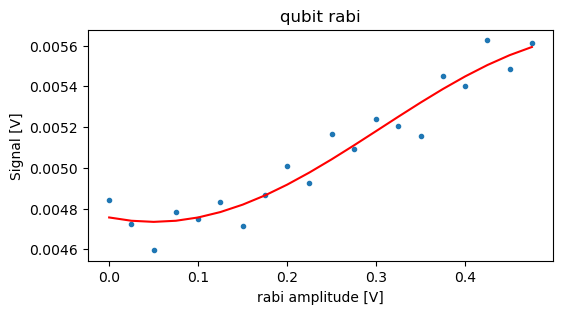

In [39]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [5]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1000 + 0.1, 2)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_I = Experiment.exp1D.Ramsey.TLS_ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 5E3, detuning = 5E6, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 10037.21s


Qubit T2* [ns]: 867.841196773383
Detuning [MHz]: 4.778648358199876
Exponent n: 1.3561270431030514


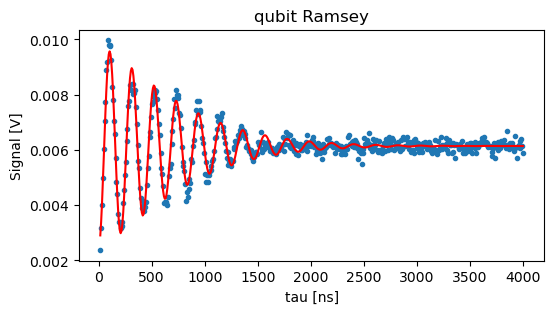

In [7]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, -sig_I,plot_flag = True)

## TLS T1 with direct driving

In [54]:
%matplotlib qt
tau_sweep_abs = np.arange(1E3,5000E3+1,5E4)
machine, tau_sweep_abs, sig_I = Experiment.exp1D.T1.TLS_T1_driving(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 5000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3747.75s


Qubit T1 [us]: 778.8301662436534


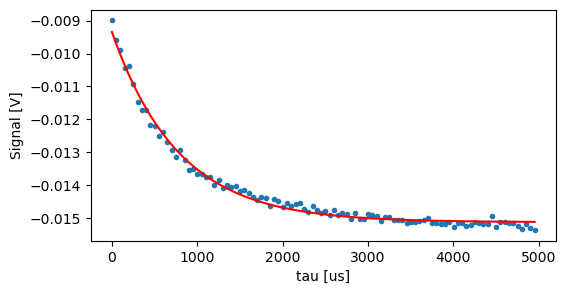

In [56]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,-sig_I,method = "exp")

# TLS Dynamical Decoupling

In [3]:
#Parameters for DD sequences
min_tau = 4
max_tau = 500
d_tau = 1

## TLS echo

In [15]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_echo(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 19998.68s


Qubit T1 [us]: 20144.10831349885


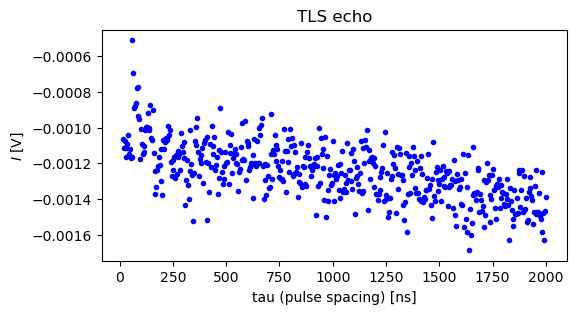

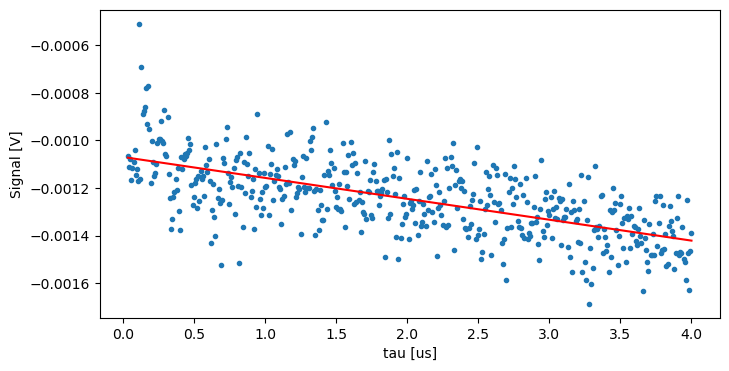

Execution stopped by user!


In [16]:
%matplotlib inline
TLS_T2e = Analysis.exp1D.T1(tau_sweep_abs*2,sig_I,method = "exp")

## TLS CPMG2

In [4]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 2, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, N_SWAP_CD = 5, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1026.07s


## TLS CPMG4

In [18]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 4, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Execution stopped by user!#######################            ] 76.7% (n=7674/10000.0) --> elapsed time: 15373.07s


## TLS CPMG6

In [19]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 6, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Execution stopped by user!                                   ] 0.0% (n=2/10000.0) --> elapsed time: 2.27s


## TLS CPMG8

In [20]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 8, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Execution stopped by user!                                   ] 0.0% (n=2/10000.0) --> elapsed time: 1.98s


## TLS CPMG10

In [21]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 10, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Execution stopped by user!                                   ] 0.0% (n=2/10000.0) --> elapsed time: 2.05s


## TLS CPMG12

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 12, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG14

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 14, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG16

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 16, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG18

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 18, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG20

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 20, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG22

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 22, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG24

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 24, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG26

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 26, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG28

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 28, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG30

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 30, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG32

In [ ]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 32, n_avg = 10E3, minus_pulse = False, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)